In [43]:
# import all tensorflow related libraries
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# import other libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
import pickle
from IPython.display import clear_output as cls
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.metrics.distance import edit_distance

In [2]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 150
LEARNING_RATE = 1e-4
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tfd.AUTOTUNE

# Training callbacks 
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_NAME + ".keras", save_best_only=True)
]

#paths
train_csv_path = "C:\\Users\\Kiki\\Downloads\\CSV\\written_name_train.csv"
valid_csv_path = "C:\\Users\\Kiki\\Downloads\\CSV\\written_name_validation.csv"
test_csv_path = "C:\\Users\\Kiki\\Downloads\\CSV\\written_name_test.csv"
train_image_dir = "C:\\Users\\Kiki\\Downloads\\train_v2"
valid_image_dir = "C:\\Users\\Kiki\\Downloads\\validation_v2\\validation"
test_image_dir = "C:\\Users\\Kiki\\Downloads\\test_v2\\test"
 


# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [3]:
# load the csv files 
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

In [4]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
# get the train labels 
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

In [6]:
# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

In [7]:
print(f"Number of unique classes(unique characters): {n_classes}")


Number of unique classes(unique characters): 44


In [8]:
# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"The length of the longest label in the datase: {MAX_LABEL_LENGTH}")

The length of the longest label in the datase: 24


In [9]:
#loading the images path
#train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
#alid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
#test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [10]:
print(train_csv['FILENAME'].head())  # Check if paths are correct


0    TRAIN_00001.jpg
1    TRAIN_00002.jpg
2    TRAIN_00003.jpg
3    TRAIN_00004.jpg
4    TRAIN_00005.jpg
Name: FILENAME, dtype: object


In [11]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [12]:
train_csv.head()

,FILENAME,IDENTITY
0,C:\Users\Kiki\Downloads\train_v2/TRAIN_00001.jpg,BALTHAZAR
1,C:\Users\Kiki\Downloads\train_v2/TRAIN_00002.jpg,SIMON
2,C:\Users\Kiki\Downloads\train_v2/TRAIN_00003.jpg,BENES
3,C:\Users\Kiki\Downloads\train_v2/TRAIN_00004.jpg,LA LOVE
4,C:\Users\Kiki\Downloads\train_v2/TRAIN_00005.jpg,DAPHNE


In [13]:
# Two dictionaries to be created Char to Num (label preprocessing
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [14]:
len(char_to_num.get_vocabulary())+1

46

In [15]:
#Image preprocessing
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image using TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [16]:
def encode_single_sample(image_path, label:str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    '''
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [17]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [18]:
# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 24000
Validation Data Size : 12000
Testing Data Size    : 2400


In [19]:
#exploring the dataset
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


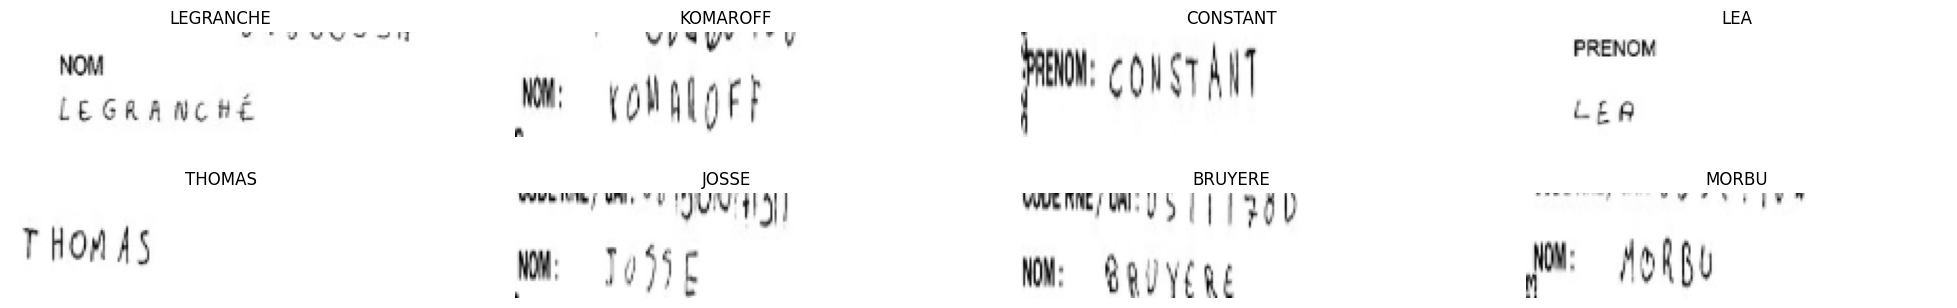

In [21]:
show_images(data=train_ds, cmap='gray')

In [22]:
# Custom CTCLayer for computing loss inside the model
@tf.keras.utils.register_keras_serializable()
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_function = tf.keras.backend.ctc_batch_cost  # TF2 compatible

    def call(self, y_true, y_pred):
        # Batch size
        batch_size = tf.shape(y_true)[0]

        # Compute input lengths (time steps) and label lengths
        input_length = tf.fill([batch_size, 1], tf.shape(y_pred)[1])
        label_length = tf.fill([batch_size, 1], tf.shape(y_true)[1])

        # Compute CTC loss
        loss = self.loss_function(y_true, y_pred, input_length, label_length)

        self.add_loss(loss)  # Ensure loss is included in the model
        return y_pred  # Return predictions for inference

# Input Layers
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")
input_labels = Input(shape=(None,), dtype="int32", name="label")

### Convolutional Layers ###
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)

conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)

### Encoding Layer ###
time_steps = IMG_WIDTH // 4  
features = (IMG_HEIGHT // 4) * 32  

reshape = Reshape(target_shape=(time_steps, features), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="encoding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="encoding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

### Decoder ###
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Output Layer
output = Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="output_dense")(lstm_2)

# Apply CTC Loss using Custom CTCLayer
ctc_loss_layer = CTCLayer()(input_labels, output)

# Define Model
model = Model(inputs=[input_images, input_labels], outputs=ctc_loss_layer)


# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 200, 50, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_1 (Conv2D)               │ (None, 200, 50, 64)       │             640 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_2 (Conv2D)               │ (None, 200, 50, 32)       │          18,464 │ conv_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 100, 25, 32)       │               0 │ conv_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_3 (Conv2D)               │ (None, 100, 25, 64)       │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_4 (Conv2D)               │ (None, 100, 25, 32)       │          18,464 │ conv_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 50, 12, 32)        │               0 │ conv_4[0][0]               │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_layer (Reshape)       │ (None, 50, 384)           │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoding_dense (Dense)        │ (None, 50, 64)            │          24,640 │ reshape_layer[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoding_dense_2 (Dense)      │ (None, 50, 64)            │           4,160 │ encoding_dense[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 50, 64)            │               0 │ encoding_dense_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_lstm_1          │ (None, 50, 256)           │         197,632 │ dropout[0][0]              │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_lstm_2          │ (None, 50, 128)           │         164,352 │ bidirectional_lstm_1[0][0] │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dense (Dense)          │ (None, 50, 46)            │           5,934 │ bidirectional_lstm_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_layer (CTCLayer)          │ (None, 50, 46)            │               

 Total params: 452,782 (1.73 MB)

 Trainable params: 452,782 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# compile the model
#adam = adaptive moment optimization
'''Adam (Adaptive Moment Estimation) is an optimization algorithm used in deep learning to adjust the weights of a neural network during training. It is an adaptive version of gradient descent that combines the advantages of two other optimizers:

Momentum → Helps the model move faster in the right direction.
RMSprop → Adjusts the learning rate for each parameter individually.
Adam automatically adjusts learning rates based on the data, making it faster and more efficient than standard gradient descent.'''
model.compile(optimizer="adam")

In [24]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 775s 249ms/step - loss: 173.6413 - val_loss: 149.9858
Epoch 2/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 596s 199ms/step - loss: 149.4610 - val_loss: 147.0232
Epoch 3/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 583s 194ms/step - loss: 146.8931 - val_loss: 145.9781
Epoch 4/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 604s 201ms/step - loss: 143.7210 - val_loss: 136.8746
Epoch 5/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 623s 208ms/step - loss: 136.0515 - val_loss: 127.0257
Epoch 6/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 673s 224ms/step - loss: 124.5376 - val_loss: 104.9678
Epoch 7/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 675s 225ms/step - loss: 103.8063 - val_loss: 89.3949
Epoch 8/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 631s 210ms/step - loss: 84.6836 - val_loss: 62.9779
Epoch 9/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 592s 197ms/step - loss: 64.1497 - val_loss: 47.4110
Epoch 10/150
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 631s 210ms/step - loss: 49.5444 - val_loss: 38.6012
Epoch 11/150
3000/3000 ━━━━━━━━━━━━━

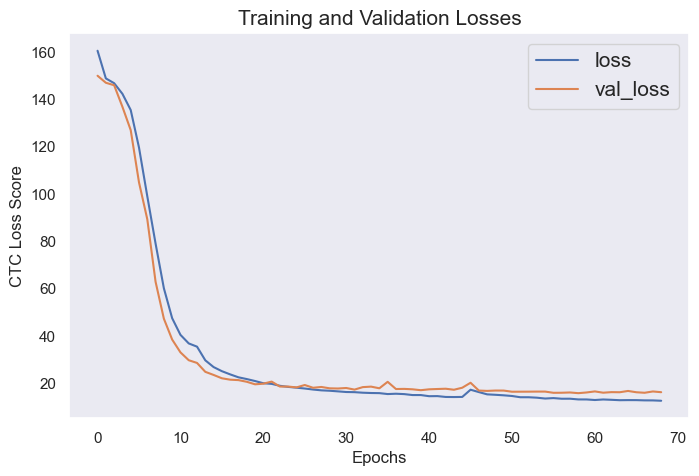

In [25]:
import seaborn as sb
# draw plot for results 
sb.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

In [26]:
import Levenshtein

In [27]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [28]:
# Ensure we correctly extract the input layer
image_input = model.input[0]  # Extract image input (first input of the model)
output_layer = model.get_layer(name="output_dense").output  # Extract softmax output

# Define the prediction model
pred_model = Model(inputs=image_input, outputs=output_layer)

# Print summary
pred_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 200, 50, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 200, 50, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 100, 25, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_layer (Reshape)              │ (None, 50, 384)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_dense (Dense)               │ (None, 50, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_dense_2 (Dense)             │ (None, 50, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm_1 (Bidirectional) │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm_2 (Bidirectional) │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (None, 50, 46)              │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,782 (1.73 MB)

 Trainable params: 452,782 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

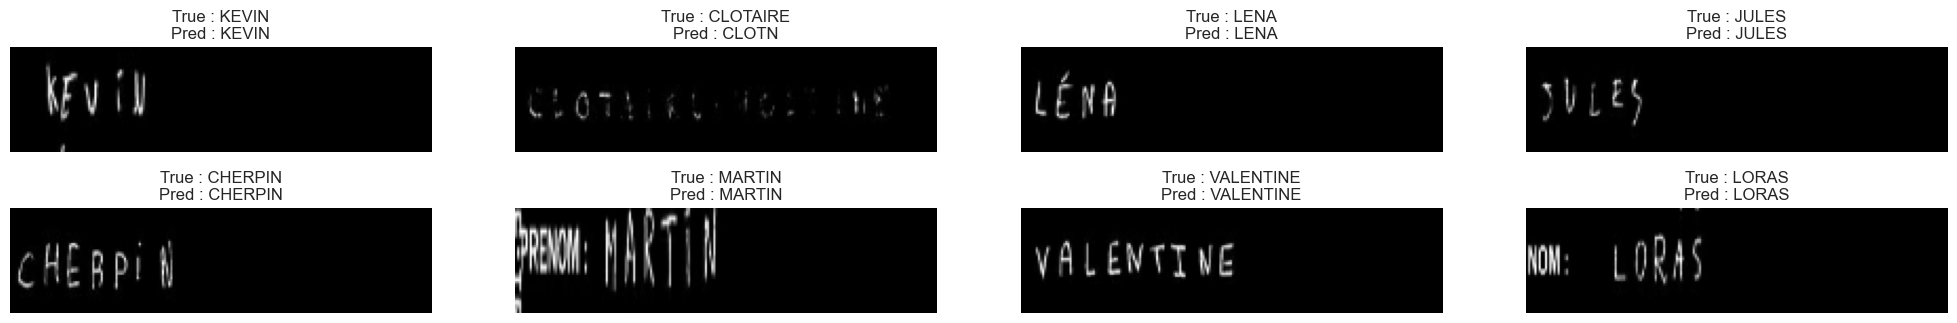

In [45]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')


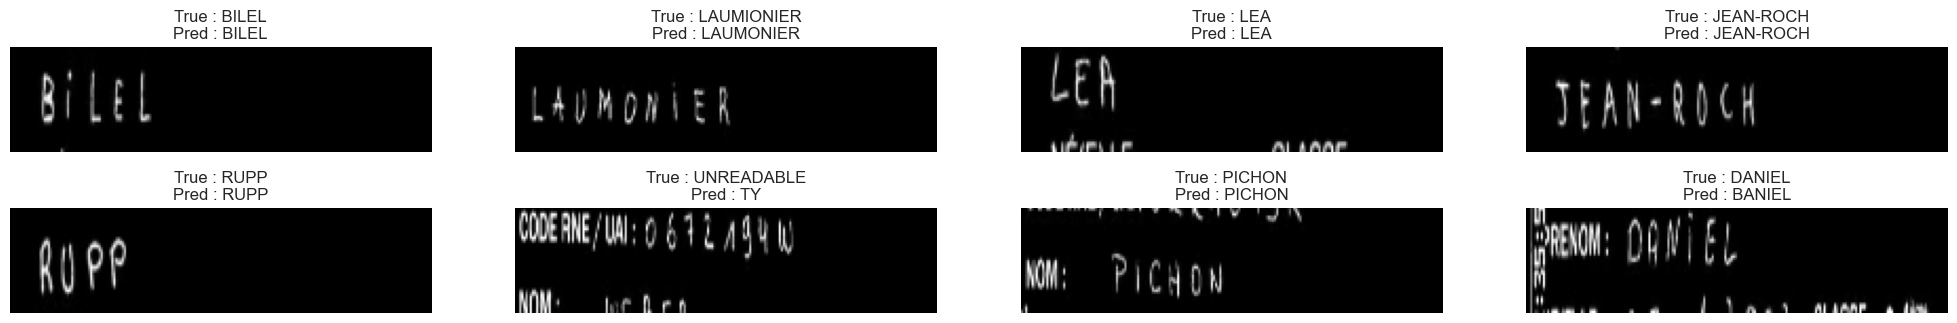

In [40]:
show_images(data=valid_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')


In [55]:
def single_sample_prediction(model, path):
    """
    This function gets an image path and the model,
    Loads and preprocesses the image and make predictions on it. 
    """
    # load image 
    image_loading = tf.io.read_file(path)
    # decode image 
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)
    # convert the image data type to float 
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize the image 
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm = [1, 0, 2])
    # convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)
    # reshape image 
    single_image_data_with_batch = np.expand_dims(image_array, axis=0)

    # make prediction 
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


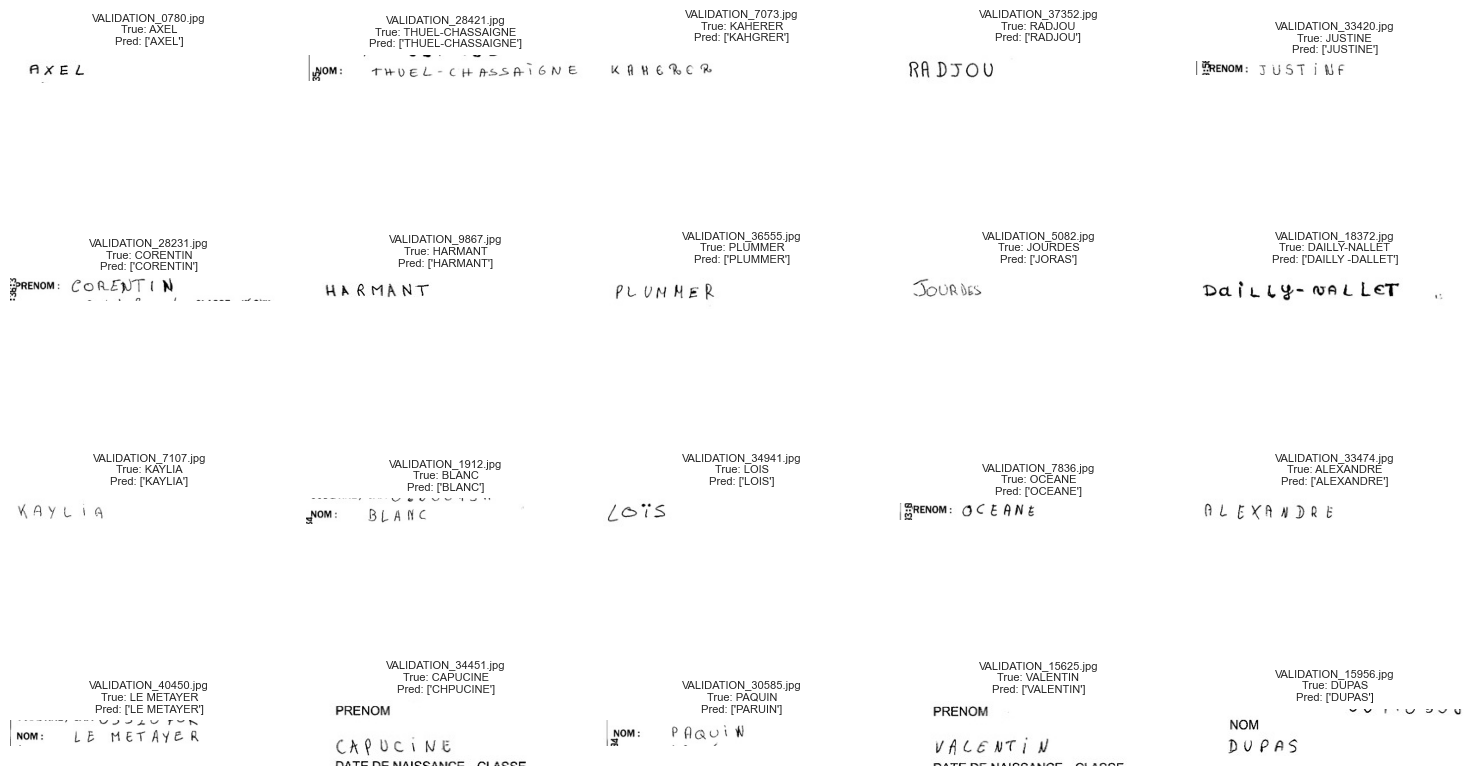

Ground Truth Labels (y_true): ['AXEL', 'THUEL-CHASSAIGNE', 'KAHERER', 'RADJOU', 'JUSTINE', 'CORENTIN', 'HARMANT', 'PLUMMER', 'JOURDES', 'DAILLY-NALLET', 'KAYLIA', 'BLANC', 'LOIS', 'OCEANE', 'ALEXANDRE', 'LE METAYER', 'CAPUCINE', 'PAQUIN', 'VALENTIN', 'DUPAS']
Predicted Labels (y_pred): [['AXEL'], ['THUEL-CHASSAIGNE'], ['KAHGRER'], ['RADJOU'], ['JUSTINE'], ['CORENTIN'], ['HARMANT'], ['PLUMMER'], ['JORAS'], ['DAILLY -DALLET'], ['KAYLIA'], ['BLANC'], ['LOIS'], ['OCEANE'], ['ALEXANDRE'], ['LE METAYER'], ['CHPUCINE'], ['PARUIN'], ['VALENTIN'], ['DUPAS']]


In [95]:
import random

# Load the validation CSV file
validation_data = pd.read_csv(valid_csv_path)



# List all files in the validation directory
all_images = [f for f in os.listdir(validation_image_dir) 
              if os.path.isfile(os.path.join(validation_image_dir, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Check if there are at least 20 images
if len(all_images) < 20:
    raise ValueError(f"Not enough images in the validation directory. Found {len(all_images)}, but 20 are required.")

# Randomly pick 20 unique images
random_images = random.sample(all_images, 20)

# Initialize lists for ground truth and predictions
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Preload all images and their data
images_and_data = []
for random_image_name in random_images:
    random_image_path = os.path.join(validation_image_dir, random_image_name)
    
    # Retrieve the ground truth label from the dictionary
    true_label = filename_to_label.get(random_image_name, "UNKNOWN")  # Default to "UNKNOWN" if not found
    y_true.append(true_label)
    
    # Load the image
    img = implt.imread(random_image_path)
    
    # Make a prediction using your OCR model
    try:
        predicted_label = single_sample_prediction(pred_model, random_image_path)
        y_pred.append(predicted_label)
    except Exception as e:
        print(f"Error during prediction for {random_image_name}: {e}")
        predicted_label = "ERROR"
        y_pred.append("ERROR")
    
    # Store the image, its name, true label, and predicted label
    images_and_data.append({
        'image': img,
        'name': random_image_name,
        'true_label': true_label,
        'predicted_label': predicted_label
    })

# Set up the grid for displaying images
num_cols = 5  # Number of columns in the grid
num_rows = 4  # Number of rows in the grid (total = 20 images)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Display all images in the grid
for i, data in enumerate(images_and_data):
    img = data['image']
    name = data['name']
    true_label = data['true_label']
    predicted_label = data['predicted_label']
    
    # Display the image in the grid
    axes[i].imshow(img)
    axes[i].set_title(f"{name}\nTrue: {true_label}\nPred: {predicted_label}", fontsize=8)
    axes[i].axis('off')  # Turn off axis for better visualization

# Adjust layout and display the grid
plt.tight_layout()
plt.show()

# Print the final lists
print("Ground Truth Labels (y_true):", y_true)
print("Predicted Labels (y_pred):", y_pred)

In [99]:
from sklearn.metrics import classification_report


# Example inputs (replace with your actual predictions)
y_true = ['AXEL', 'THUEL-CHASSAIGNE', 'KAHERER', 'RADJOU', 'JUSTINE', 'CORENTIN', 'HARMANT', 'PLUMMER', 'JOURDES', 'DAILLY-NALLET', 'KAYLIA', 'BLANC', 'LOIS', 'OCEANE', 'ALEXANDRE', 'LE METAYER', 'CAPUCINE', 'PAQUIN', 'VALENTIN', 'DUPAS']
y_pred = ['AXEL', 'THUEL-CHASSAIGNE', 'KAHGRER', 'RADJOU', 'JUSTINE', 'CORENTIN', 'HARMANT', 'PLUMMER', 'JORAS', 'DAILLY -DALLET', 'KAYLIA', 'BLANC', 'LOIS', 'OCEANE', 'ALEXANDRE', 'LE METAYER', 'CHPUCINE', 'PARUIN', 'VALENTIN', 'DUPAS']
# Calculate metrics for word-level evaluation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f"Word-Level Accuracy: {accuracy:.4f}")
print(f"Word-Level Precision: {precision:.4f}")
print(f"Word-Level Recall: {recall:.4f}")
print(f"Word-Level F1 Score: {f1:.4f}")

# Calculate normalized edit distance
total_distance = sum(edit_distance(true_word, pred_word) for true_word, pred_word in zip(y_true, y_pred))
total_length = sum(len(true_word) for true_word in y_true)
normalized_edit_distance = total_distance / total_length

print(f"Normalized Edit Distance: {normalized_edit_distance:.4f}")

# Assuming y_true and y_pred are your true labels and predicted labels, respectively
print(classification_report(y_true, y_pred, zero_division=0))

Word-Level Accuracy: 0.7500
Word-Level Precision: 0.7500
Word-Level Recall: 0.7500
Word-Level F1 Score: 0.7500
Normalized Edit Distance: 0.0537
                  precision    recall  f1-score   support

       ALEXANDRE       1.00      1.00      1.00         1
            AXEL       1.00      1.00      1.00         1
           BLANC       1.00      1.00      1.00         1
        CAPUCINE       0.00      0.00      0.00         1
        CHPUCINE       0.00      0.00      0.00         0
        CORENTIN       1.00      1.00      1.00         1
  DAILLY -DALLET       0.00      0.00      0.00         0
   DAILLY-NALLET       0.00      0.00      0.00         1
           DUPAS       1.00      1.00      1.00         1
         HARMANT       1.00      1.00      1.00         1
           JORAS       0.00      0.00      0.00         0
         JOURDES       0.00      0.00      0.00         1
         JUSTINE       1.00      1.00      1.00         1
         KAHERER       0.00      0.00      

C:\Users\Kiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Normalized Edit Distances: [0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42857142857142855, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.16666666666666666, 0.0, 0.0]


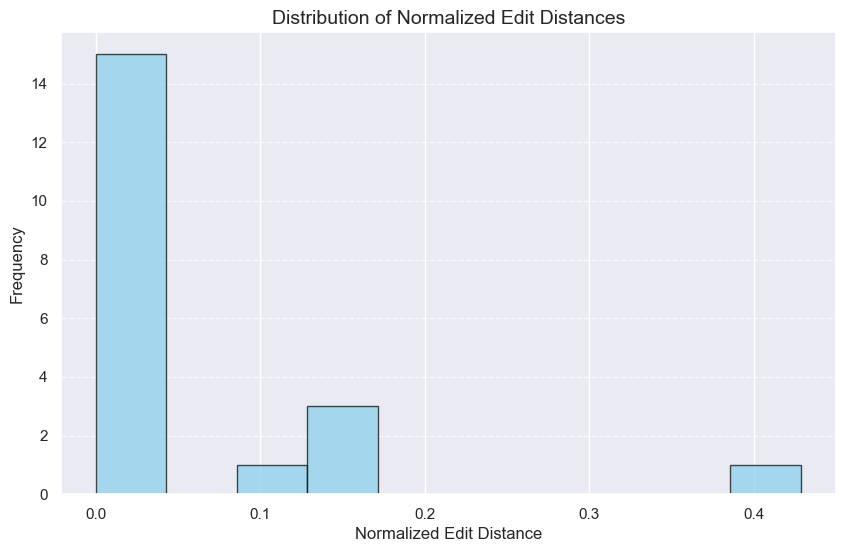

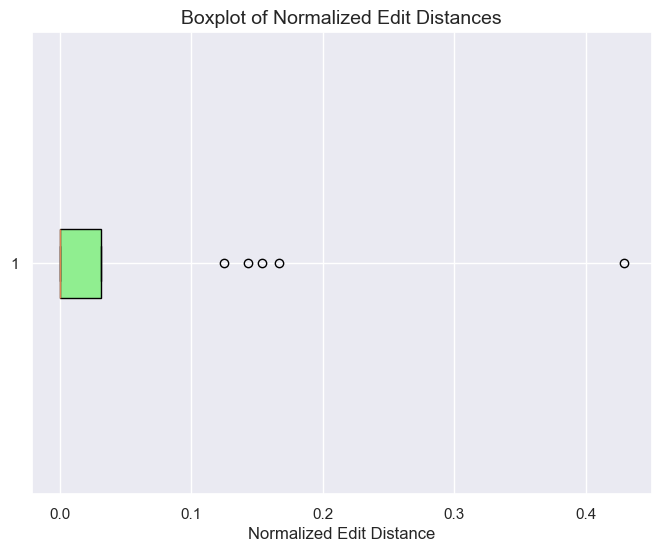

Mean Normalized Edit Distance: 0.0508
Median Normalized Edit Distance: 0.0000
Standard Deviation: 0.1047


<Figure size 640x480 with 0 Axes>

In [103]:

from nltk.metrics.distance import edit_distance

# Example inputs (replace with your actual predictions)
y_true = ['AXEL', 'THUEL-CHASSAIGNE', 'KAHERER', 'RADJOU', 'JUSTINE', 'CORENTIN', 'HARMANT', 'PLUMMER', 'JOURDES', 'DAILLY-NALLET', 
          'KAYLIA', 'BLANC', 'LOIS', 'OCEANE', 'ALEXANDRE', 'LE METAYER', 'CAPUCINE', 'PAQUIN', 'VALENTIN', 'DUPAS']
y_pred = ['AXEL', 'THUEL-CHASSAIGNE', 'KAHGRER', 'RADJOU', 'JUSTINE', 'CORENTIN', 'HARMANT', 'PLUMMER', 'JORAS', 'DAILLY -DALLET', 
          'KAYLIA', 'BLANC', 'LOIS', 'OCEANE', 'ALEXANDRE', 'LE METAYER', 'CHPUCINE', 'PARUIN', 'VALENTIN', 'DUPAS']

# Calculate normalized edit distances
normalized_edit_distances = []
for true_word, pred_word in zip(y_true, y_pred):
    distance = edit_distance(true_word, pred_word)  # Compute Levenshtein distance
    normalized_distance = distance / len(true_word) if len(true_word) > 0 else 0  # Normalize by length of true word
    normalized_edit_distances.append(normalized_distance)

# Print normalized edit distances for debugging
print("Normalized Edit Distances:", normalized_edit_distances)

# Plot the Levenshtein distance graph (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(normalized_edit_distances, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Normalized Edit Distances', fontsize=14)
plt.xlabel('Normalized Edit Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot for better visualization of distribution
plt.figure(figsize=(8, 6))
plt.boxplot(normalized_edit_distances, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot of Normalized Edit Distances', fontsize=14)
plt.xlabel('Normalized Edit Distance', fontsize=12)
plt.show()

# Print summary statistics

print(f"Mean Normalized Edit Distance: {np.mean(normalized_edit_distances):.4f}")
print(f"Median Normalized Edit Distance: {np.median(normalized_edit_distances):.4f}")
print(f"Standard Deviation: {np.std(normalized_edit_distances):.4f}")

plt.savefig('levenshtein_histogram.png')
plt.savefig('levenshtein_boxplot.png')

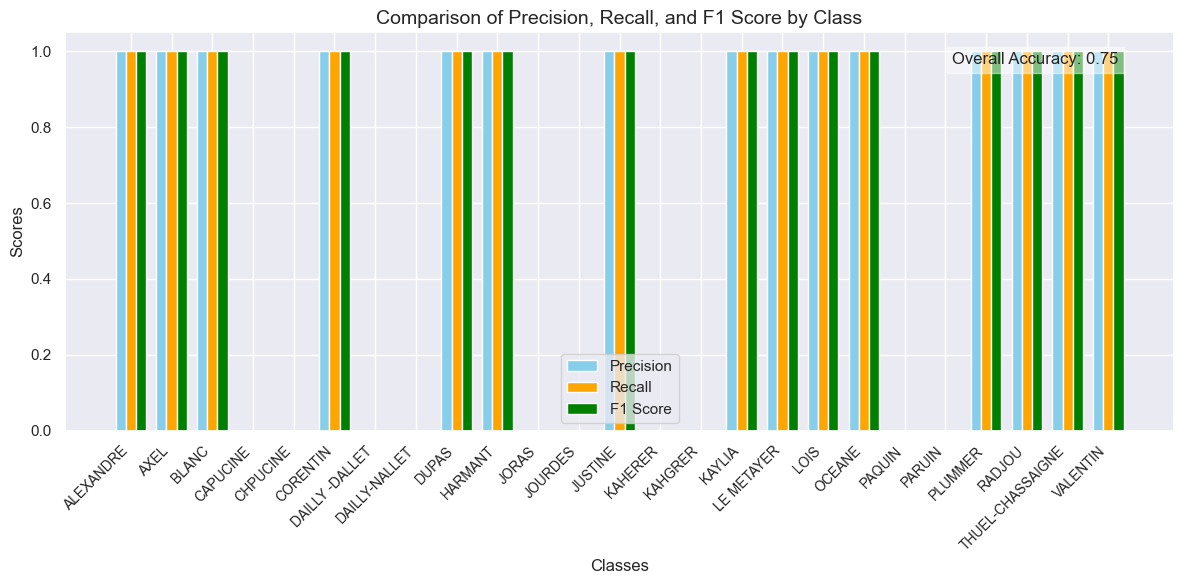

In [102]:
#RECALL CLASSIFICATION REPORT
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
# Extract metrics for each class
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]



# Plot metrics using grouped bar chart
x = np.arange(len(classes))  # X-axis positions for the classes
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for precision, recall, and F1 score
bars_precision = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bars_recall = ax.bar(x, recall, width, label='Recall', color='orange')
bars_f1 = ax.bar(x + width, f1_score, width, label='F1 Score', color='green')

# Add overall accuracy as text
ax.text(0.95, 0.95, f'Overall Accuracy: {accuracy:.2f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Add labels, title, and legend
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Precision, Recall, and F1 Score by Class', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=10)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [105]:
# save the model
model.save("character_recognition_model_2.keras")
# save weights
model.save_weights("character_model_2.weights.h5")